In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean, stdev, median
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multitest as smm
import seaborn as sns

files = os.listdir('data')
df = pd.concat([pd.read_csv('data/' + file) for file in files if 'part' in file], ignore_index=True)
print(df.head())

   participant_id     timestamp  time_to_finish     ui_mode environment  \
0              10  1.741882e+12          2217.0  light_mode    dark_env   
1              10  1.741882e+12         18175.0  light_mode    dark_env   
2              10  1.741882e+12          1824.0  light_mode    dark_env   
3              10  1.741882e+12          2432.0  light_mode    dark_env   
4              10  1.741882e+12          7440.0  light_mode    dark_env   

  fill_character outlier_character  trial  trial_combined  
0              o                 e    1.0             1.0  
1              0                 8    2.0             2.0  
2              v                 u    3.0             3.0  
3              T                 7    4.0             4.0  
4              e                 o    5.0             5.0  


# Mean times for each setting

In [3]:
mean_time_to_finish_dark_env = df[df["environment"] == "dark_env"]["time_to_finish"].mean()
mean_time_to_finish_light_env = df[df['environment'] == 'light_env']['time_to_finish'].mean()
means = [mean_time_to_finish_dark_env, mean_time_to_finish_light_env]
print(means)

[np.float64(8539.231491136601), np.float64(8551.074035453597)]


In [4]:
median_time_to_finish_dark_mode_dark_env = df[(df["ui_mode"] == "dark_mode") & (df['environment'] == 'dark_env')]["time_to_finish"].median()
median_time_to_finish_light_mode_light_env = df[(df['ui_mode'] == 'light_mode') & (df['environment'] == 'light_env')]['time_to_finish'].median()
median_time_to_finish_dark_mode_light_env = df[(df["ui_mode"] == "dark_mode") & (df['environment'] == 'light_env')]["time_to_finish"].median()
median_time_to_finish_light_mode_dark_env = df[(df['ui_mode'] == 'light_mode') & (df['environment'] == 'dark_env')]['time_to_finish'].median()

modes_with_environments = [median_time_to_finish_dark_mode_dark_env, median_time_to_finish_dark_mode_light_env, median_time_to_finish_light_mode_light_env, median_time_to_finish_light_mode_dark_env]

print(modes_with_environments)

[np.float64(5669.0), np.float64(4568.0), np.float64(3655.5), np.float64(3296.0)]


In [5]:
t_med_darkmode = df[df['ui_mode'] == 'dark_mode']['time_to_finish'].median()
t_med_lightmode = df[df['ui_mode'] == 'light_mode']['time_to_finish'].median()

t_med_darkenv = df[df['environment'] == 'dark_env']['time_to_finish'].median()
t_med_lightenv = df[df['environment'] == 'light_env']['time_to_finish'].median()

t_med_combined = df['time_to_finish'].median()

print(t_med_darkmode)
print(t_med_lightmode)
print(t_med_darkenv)
print(t_med_lightenv)
print(t_med_combined)

4945.0
3496.0
4136.0
4008.0
4084.0


In [6]:
with open('data/StudyResults.tsv', 'r') as tsvfile:
    content = tsvfile.read()
    content = content.replace('\t', ',')
    with open ('data/eye_tracking_data.csv', 'w') as csvfile:
        csvfile.write(content)
        

In [7]:
df_eye =  pd.read_csv('data/eye_tracking_data.csv')
df_eye['blinks_per_minute'] = df_eye['Number_of_blinks'] / (df_eye['Duration_of_interval'] / 60000)

In [8]:
blinks_dark_in_dark = df_eye[(df_eye['TOI'] == 'DarkE_DarkM') & (df_eye['blinks_per_minute'] != 0)]['blinks_per_minute'].mean()
blinks_dark_in_light = df_eye[(df_eye['TOI'] == 'LightE_DarkM') & (df_eye['blinks_per_minute'] != 0)]['blinks_per_minute'].mean()

blinks_light_in_dark = df_eye[(df_eye['TOI'] == 'DarkE_LightM') & (df_eye['blinks_per_minute'] != 0)]['blinks_per_minute'].mean()
blinks_light_in_light = df_eye[(df_eye['TOI'] == 'LightE_LightM') & (df_eye['blinks_per_minute'] != 0)]['blinks_per_minute'].mean()

blinks_light_mode = (blinks_light_in_dark + blinks_light_in_light) / 2
blinks_dark_mode = (blinks_dark_in_light + blinks_dark_in_dark) / 2

blinks_light_env = (blinks_dark_in_light + blinks_light_in_light) / 2
blinks_dark_env = (blinks_dark_in_dark + blinks_light_in_dark) / 2

blinks_mean = (blinks_light_mode + blinks_dark_mode + blinks_light_env + blinks_dark_env) / 4

# Actual try of doing this somewhat usefully

- prep data for 2-way anova tests

In [9]:
dataframe_time = pd.DataFrame()
dataframe_blinks = pd.DataFrame()

dataframe_time['part'] = df['participant_id']
dataframe_time['env'] = df['environment']
dataframe_time['mode'] = df['ui_mode']
dataframe_time['time'] = df['time_to_finish']

dataframe_blinks = df_eye[df_eye['TOI'].str.contains('_')].copy()
dataframe_blinks['part'] = df_eye['Participant']
dataframe_blinks[['environment', 'ui_mode']] = dataframe_blinks['TOI'].str.split('_', expand=True)
dataframe_blinks['number_of_blinks'] = df_eye['Number_of_blinks']
dataframe_blinks['duration_in_minutes'] = df_eye['Duration_of_interval'] / 60000 
dataframe_blinks['blinks_per_minute'] = df_eye['Number_of_blinks'] / (df_eye['Duration_of_interval'] / 60000)
dataframe_blinks = dataframe_blinks[[
    'part',
    'environment',
    'ui_mode',
    'number_of_blinks',
    'duration_in_minutes',
    'blinks_per_minute'
]]


#Exclude blink errors

dataframe_blinks = dataframe_blinks[dataframe_blinks['blinks_per_minute'] > 0]

print(dataframe_time.head())
print(dataframe_blinks.head())

   part       env        mode     time
0    10  dark_env  light_mode   2217.0
1    10  dark_env  light_mode  18175.0
2    10  dark_env  light_mode   1824.0
3    10  dark_env  light_mode   2432.0
4    10  dark_env  light_mode   7440.0
  part environment ui_mode  number_of_blinks  duration_in_minutes  \
0   P3       DarkE   DarkM                75             8.276933   
1   P3       DarkE  LightM                31             4.772433   
2   P3      LightE   DarkM                27             6.969283   
3   P3      LightE  LightM                23             4.191400   
5   P4       DarkE   DarkM               159             8.980467   

   blinks_per_minute  
0           9.061327  
1           6.495638  
2           3.874143  
3           5.487427  
5          17.705093  


# Run 2-way anova test

In [11]:
dataframe_time['env'] = dataframe_time['env'].astype('category')
dataframe_time['mode'] = dataframe_time['mode'].astype('category')

model_time = ols('time ~ C(env) * C(mode)', data=dataframe_time).fit()

anova_time = sm.stats.anova_lm(model_time, typ=2)

print(anova_time)

dataframe_blinks['environment'] = dataframe_blinks['environment'].astype('category')
dataframe_blinks['ui_mode'] = dataframe_blinks['ui_mode'].astype('category')

model_blinks = ols('blinks_per_minute ~ C(environment) * C(ui_mode)', data=dataframe_blinks).fit()

anova_blinks = sm.stats.anova_lm(model_blinks, typ=2)

print(anova_blinks)

                      sum_sq      df          F        PR(>F)
C(env)          1.178074e+05     1.0   0.000607  9.803476e-01
C(mode)         6.475204e+09     1.0  33.360710  8.914332e-09
C(env):C(mode)  4.635839e+07     1.0   0.238842  6.250999e-01
Residual        3.715011e+11  1914.0        NaN           NaN
                                sum_sq    df         F    PR(>F)
C(environment)                7.750770   1.0  0.151101  0.699547
C(ui_mode)                    8.442099   1.0  0.164578  0.687138
C(environment):C(ui_mode)    21.246425   1.0  0.414198  0.523519
Residual                   2051.811292  40.0       NaN       NaN


# Run bonferroni corrected t-test for significant stat

In [12]:
light_mode_times = dataframe_time[dataframe_time['mode'] == 'light_mode']['time']
dark_mode_times = dataframe_time[dataframe_time['mode'] == 'dark_mode']['time']

t_stat, p_value = ttest_ind(light_mode_times, dark_mode_times, equal_var=False)

_, p_corrected, _, _ = smm.multipletests([p_value], method='bonferroni')

print(f"T-statistic: {t_stat:.4f}")
print(f"Original p-value: {p_value:.6f}")
print(f"Bonferroni-corrected p-value: {p_corrected[0]:.6f}")

NameError: name 'ttest_ind' is not defined

# Visualuze anova for time

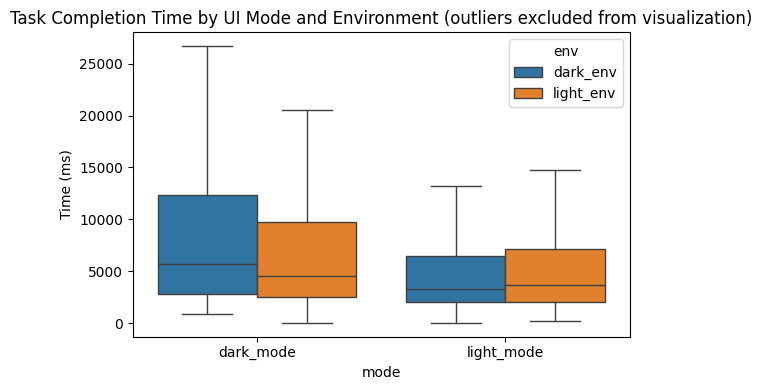

In [ ]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='mode', y='time', hue='env', data=dataframe_time, showfliers=False)
plt.title("Task Completion Time by UI Mode and Environment (outliers excluded from visualization)")
plt.ylabel("Time (ms)")
plt.tight_layout()
plt.show()

# Visulaize anova for blink rate

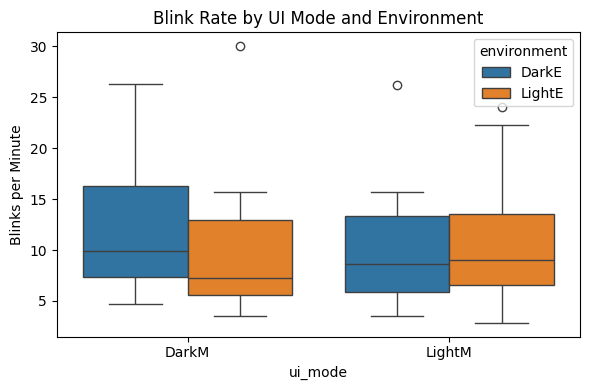

In [ ]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='ui_mode', y='blinks_per_minute', hue='environment', data=dataframe_blinks)
plt.title("Blink Rate by UI Mode and Environment")
plt.ylabel("Blinks per Minute")
plt.tight_layout()
plt.show()

# Visualize of t-test comparison

C:\Users\patri\AppData\Local\Temp\ipykernel_23560\3865460178.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_times = dataframe_time.groupby(['mode', 'env'])['time'].mean().reset_index()


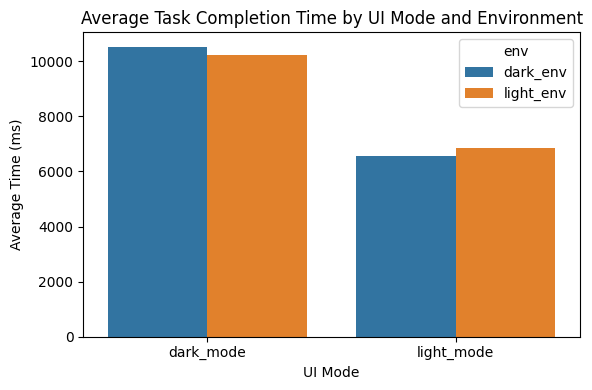

In [ ]:
# Calculate mean time for each combination of 'mode' and 'env'
mean_times = dataframe_time.groupby(['mode', 'env'])['time'].mean().reset_index()

# Barplot to show mean task completion times
plt.figure(figsize=(6, 4))
sns.barplot(x='mode', y='time', hue='env', data=mean_times)
plt.title("Average Task Completion Time by UI Mode and Environment")
plt.ylabel("Average Time (ms)")
plt.xlabel("UI Mode")
plt.tight_layout()
plt.show()